In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set()
mpl.rcParams[u'font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
dataDir = "ML data"
df = pd.read_pickle("%s/tsData.pkl" % dataDir, compression="bz2")

In [3]:
citys = ['北京', '上海', '广州', '深圳', '成都', '重庆', '杭州', '西安']

In [4]:
def getData(city):
    return df[(df['车型new']=='A4L')&(df['城市']==city)][['月份', '城市汇总']].reset_index(drop=True).copy()

In [5]:
def dGraph(rows, cols, df):
    r, c  = 0, 0
    xlist = df.shape[0]
    print(xlist)
    # plt.figure(figsize=(800, 100))
    figure, ax = plt.subplots(rows, cols, figsize=(40, 20),sharex="col")
    for colname in df:
        ax[r][c].plot(range(xlist), df[colname])
        ax[r][c].set_title(u"%s" % colname)
        if c < cols-1:
            c += 1
        else:
            c = 0
            r += 1
    plt.show()

In [6]:
def newdata(citys):
    i = 0
    tmpdf = pd.DataFrame()
    for city in citys:
        # print(city)
        tmpdf[city] = getData(city)['城市汇总'].values
    return tmpdf

In [7]:
cityDF = newdata(citys)

39


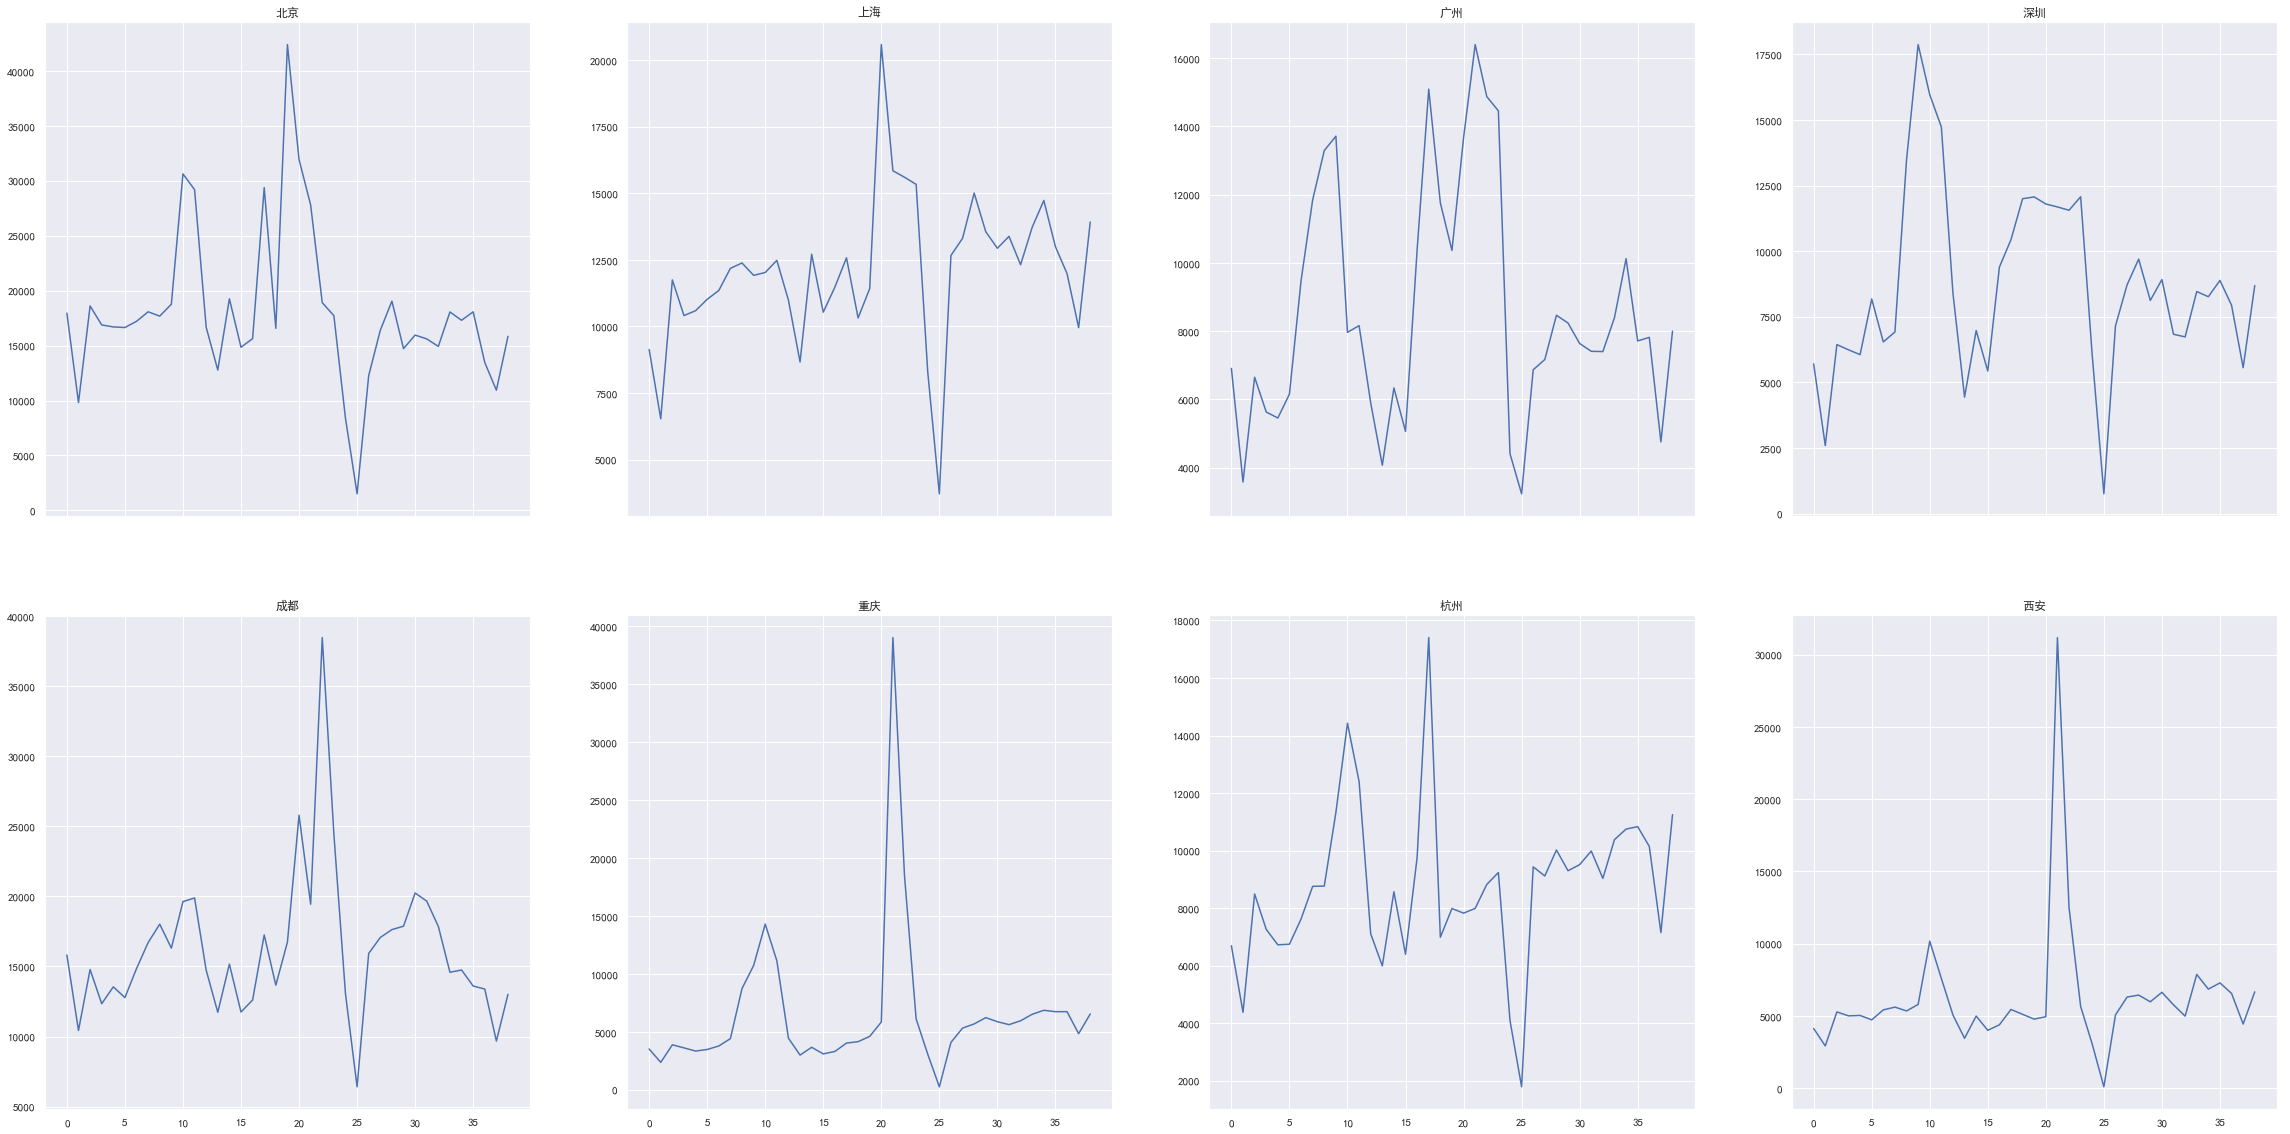

In [8]:
dGraph(2, 4, cityDF)

In [9]:
testdf = df[(df['车型new']=='A4L')&(df['城市']=='上海')][['城市', '月份', '城市汇总']].reset_index(drop=True).copy()

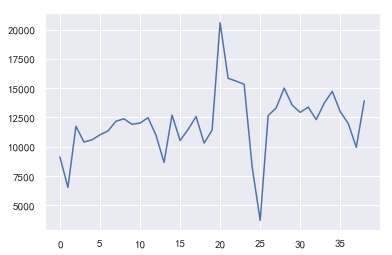

In [10]:
plt.plot(testdf['城市汇总'])

In [11]:
def avgPeak(maxidx, minidx):
    # 因为2019年9月值过大，所以需要将其减少到合理的范畴，否则会影响后续的趋势
    # 同时，2020年2月因ncov的问题，导致数据过低，同样影响后续趋势
    # 直接使用周期内的平均值(12个月前 + 12个月后)/2
    return int(testdf.loc[[maxidx-12, maxidx+12], '城市汇总'].mean()), int(testdf.loc[[minidx-12, minidx+12], '城市汇总'].mean())

In [12]:
newmax, newmin = avgPeak(np.argmax(testdf['城市汇总']), np.argmin(testdf['城市汇总']))

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [13]:
testdf.loc[np.argmax(testdf['城市汇总']), '城市汇总'] = newmax
testdf.loc[np.argmin(testdf['城市汇总']), '城市汇总'] = newmin

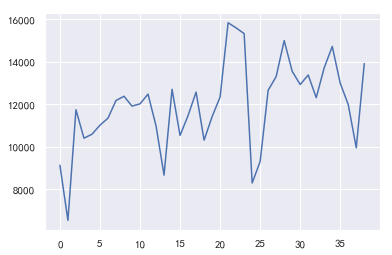

In [14]:
plt.plot(testdf['城市汇总'])

In [15]:
# maxv = testdf.loc[20, '城市汇总']
# testdf.loc[20, '城市汇总'] = int(maxv*0.8)
# minv = testdf.loc[25, '城市汇总']
# testdf.loc[25, '城市汇总'] = int(minv*1.6)

In [16]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
    
    def init_trend(self):
        s = 0.0
        for i in range(self.slen):
            s += (self.series[i+self.slen] - self.series[i])/self.slen
        return s / self.slen
    
    def init_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(series)/self.slen)
        
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j: self.slen*(j+1)])/self.slen)
        
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals
    
    def triple_expotential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.init_seasonal_components()
        
        for i in range(len(self.series) + self.n_preds):
            if i == 0:
                smooth = self.series[0]
                trend = self.init_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
                self.PredictedDeviation.append(0)
                self.UpperBond.append(
                    self.result[0] +
                    self.scaling_factor *
                    self.PredictedDeviation[0]
                )
                self.LowerBond.append(
                    self.result[0] -
                    self.scaling_factor *
                    self.PredictedDeviation[0]
                )
                continue
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append(smooth + m * trend + seasonals[i % self.slen])
                
                self.PredictedDeviation.append(
                    self.PredictedDeviation[-1] * 1.01
                )
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])
                
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i]) +
                    (1 - self.gamma) * self.PredictedDeviation[-1]
                )
            
            self.UpperBond.append(
                self.result[-1] +
                self.scaling_factor *
                self.PredictedDeviation[-1]
            )
            
            self.LowerBond.append(
                self.result[-1] -
                self.scaling_factor *
                self.PredictedDeviation[-1]
            )
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [17]:
#model = HoltWinters()